In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed

# Reading Data

Our first step is to read the dhapefiles and the speeds from the Statistics Canada data set.

In [2]:
# dfphh = pd.read_csv('NBD_PHH_SPEED_BINS_AB.csv')
dfmap = gpd.read_file("NBD_Roads_Shapefile/NBD_ROAD_SPEEDS.shp").to_crs(epsg=4326)

And here, a shapefile of the provinces of Canada

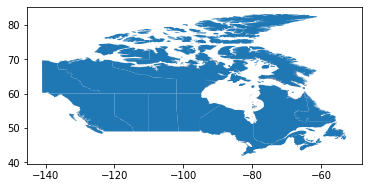

In [3]:
dfcan = gpd.read_file("newshape/lpr_000b16a_e.shp").to_crs(epsg=4326)
dfab = dfcan[dfcan.PRNAME == 'Alberta']
dfcan.plot()

As the data is coded with binary yes/no if a network line can support a certain speed or not, this is a simple transformation to determine the maximum available speed on each segment. The idea being here is that if we want to see what is available for Albertans, it may be reasonable to assume they can get the maximum available in their particular region.

In [4]:
def max_avail(row):
    if row.Avail_50_1 == 1:
        return 50
    if row.Avail_25_5 == 1:
        return 25
    if row.Avail_10_2 == 1:
        return 10
    if row.Avail_5_1_ == 1:
        return 5
    else:
        return 0
dfmap["max_speed"] = dfmap.apply(max_avail, axis =1 )
dfmap['points'] = dfmap.apply(lambda x: [y for y in x['geometry'].coords], axis=1)

Here we are converting each line segment to each of its lat/long coordinates so that we may make a heatmap. 

In [6]:

def pointsrtactor(df):
    pdict = {'lat':[], 'long':[], 'speed':[]}
    for row in df.iterrows():
        for tup in row[1]['points']:
            pdict['lat'].extend([tup[1]])
            pdict['long'].extend([tup[0]])
            pdict['speed'].extend([row[1]['max_speed']])
    return pd.DataFrame(pdict)
        
for_map = pointsrtactor(dfmap)        
      

These functions below do a couple of things
1. `make_patch` This function will create a patch for each province/region we wish to visualize separately
2. `make_interp`, This function creates the interpolation of our network data
3. `make_plot`, This is our main plotting funciton

By running the codes below, you will initially generate the interpolation, then generate each patch and print them.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


done interp
starting Newfoundland and Labrador


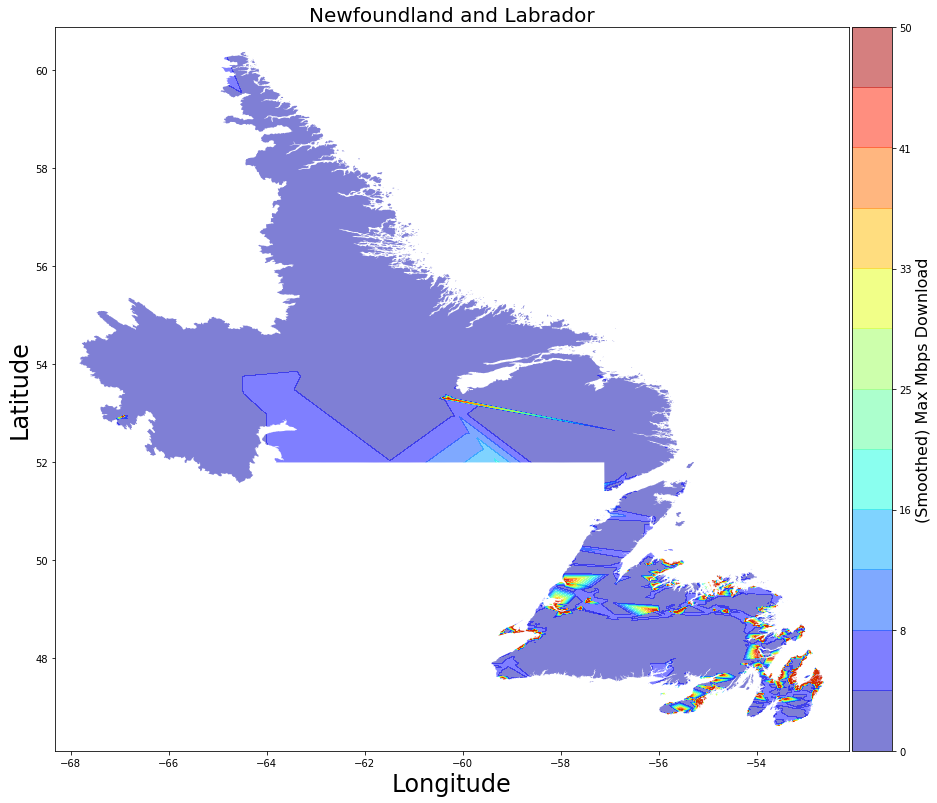

starting Prince Edward Island


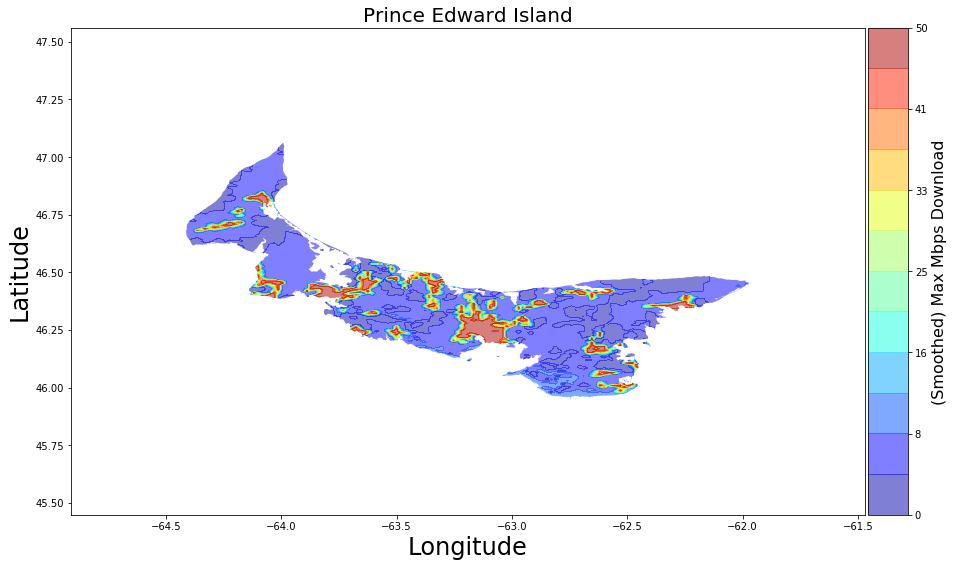

starting Nova Scotia


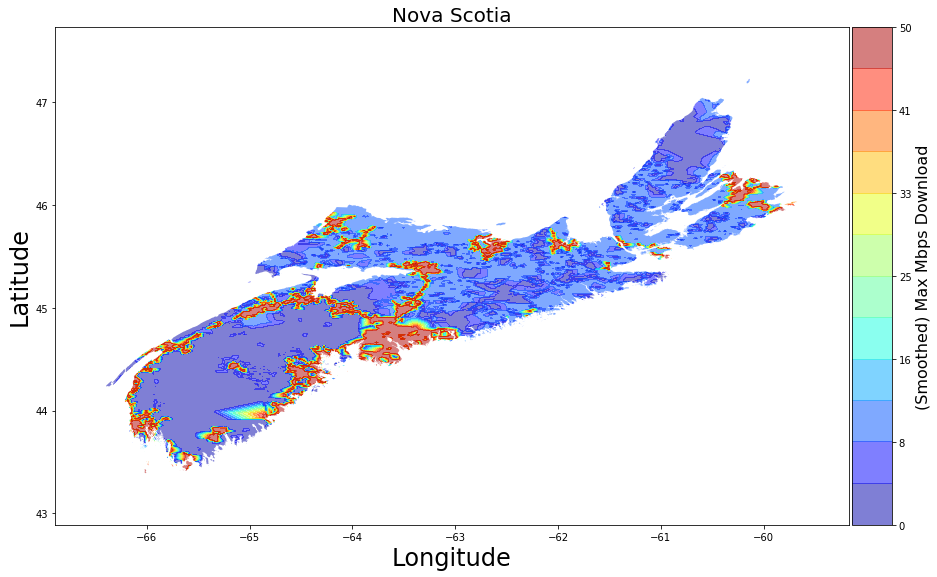

starting New Brunswick


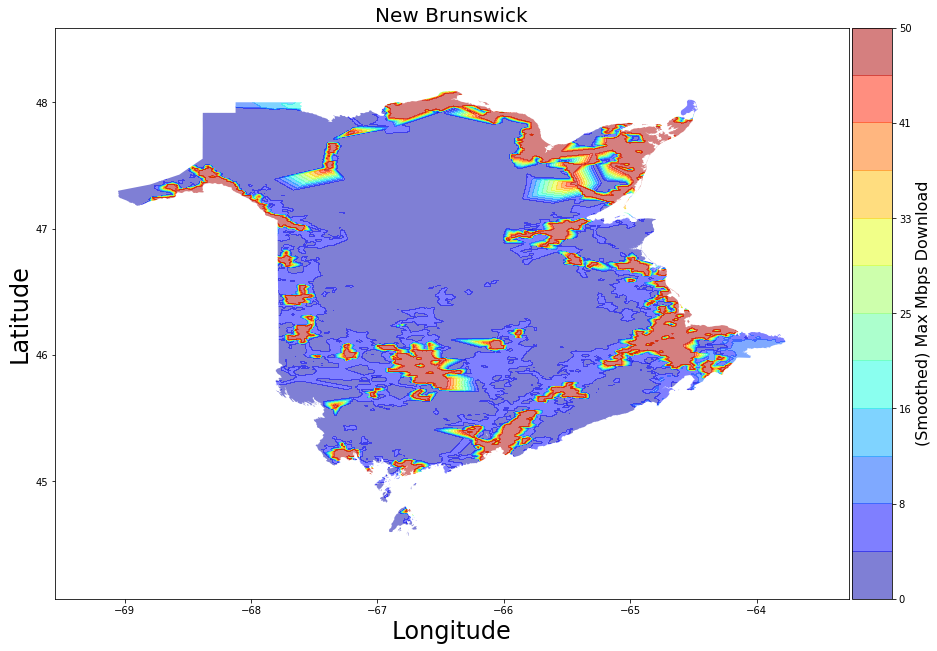

starting Quebec


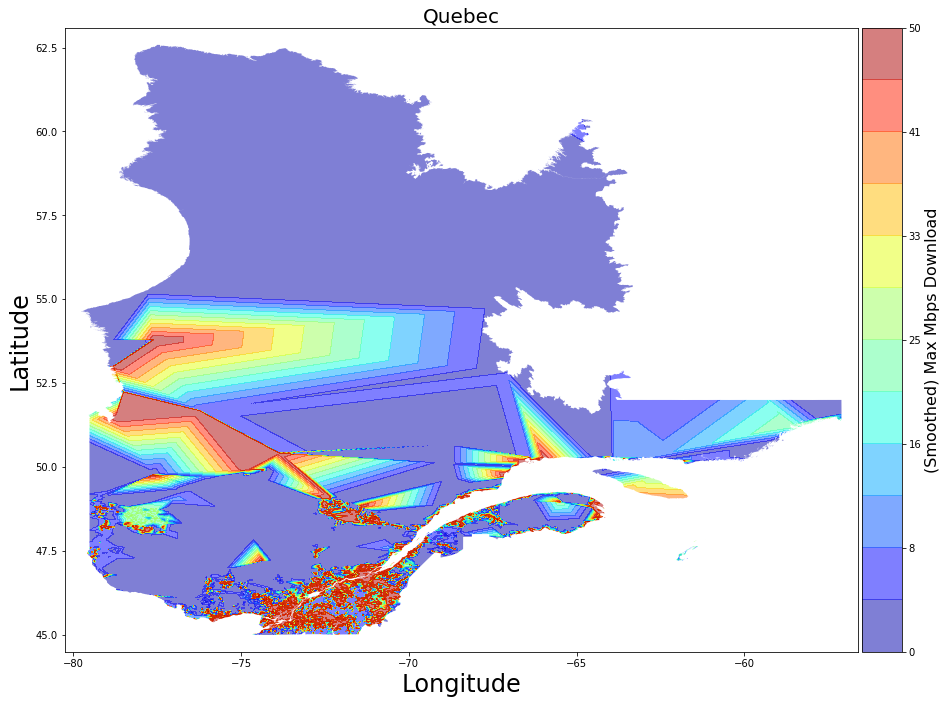

starting Ontario


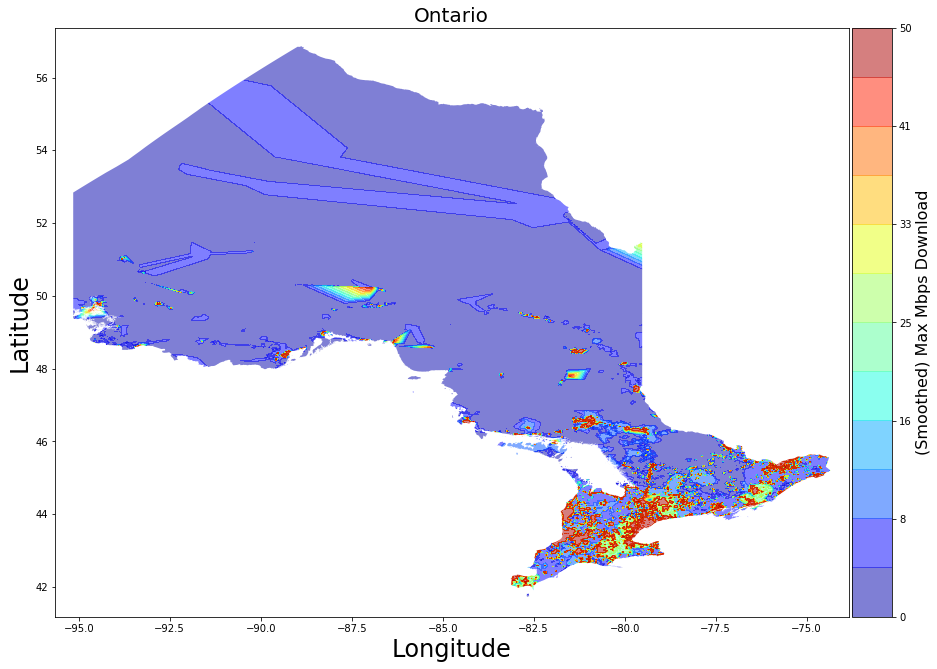

starting Manitoba


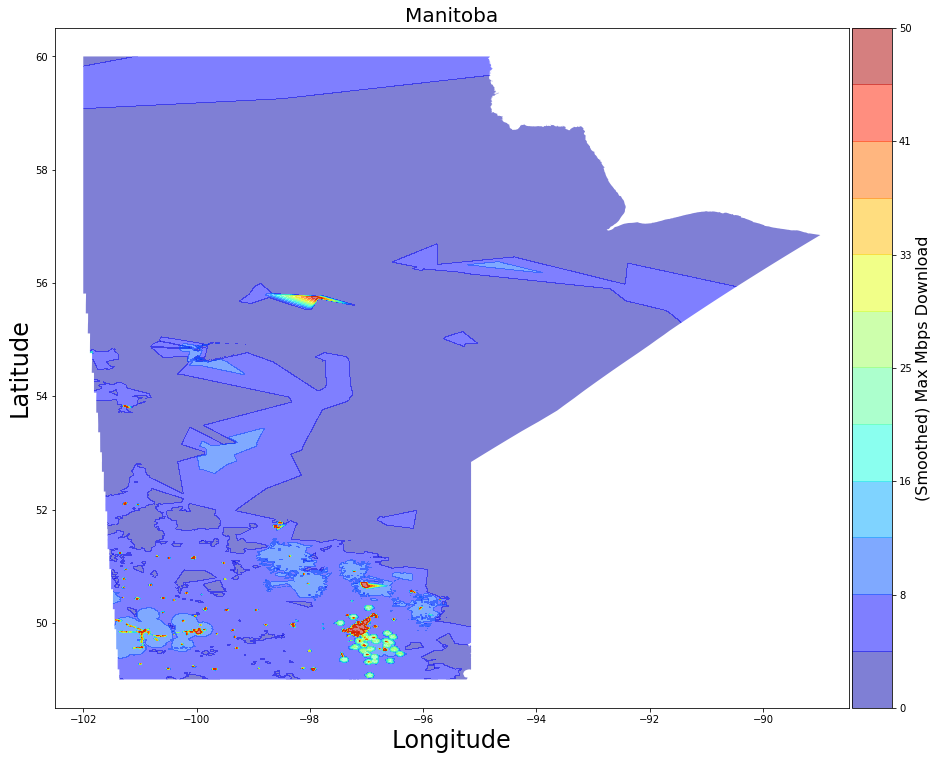

starting Saskatchewan


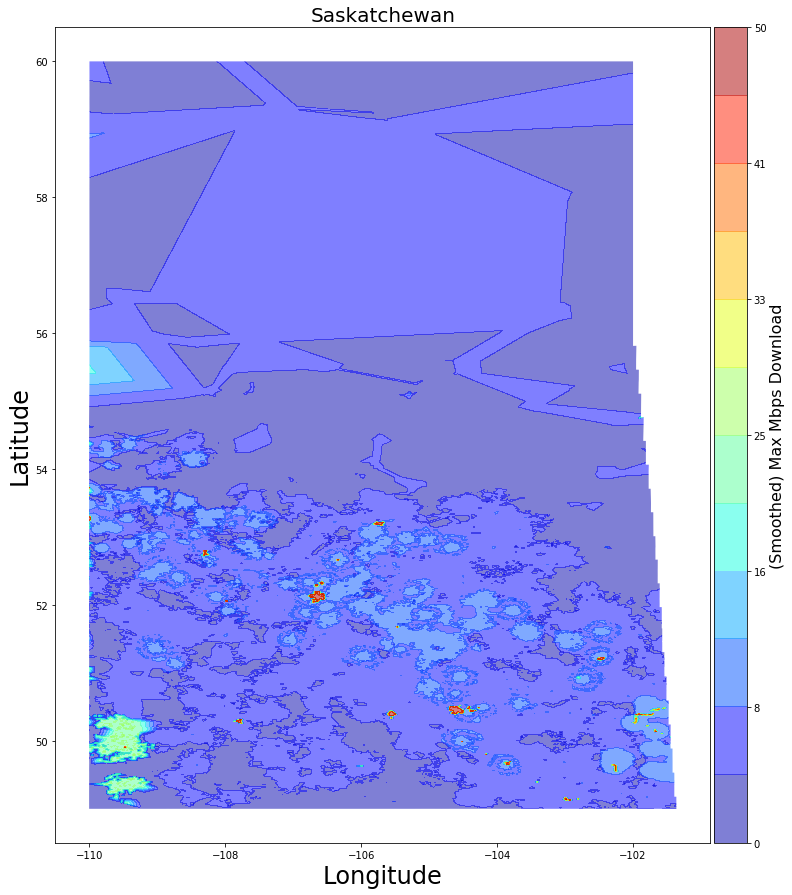

starting Alberta


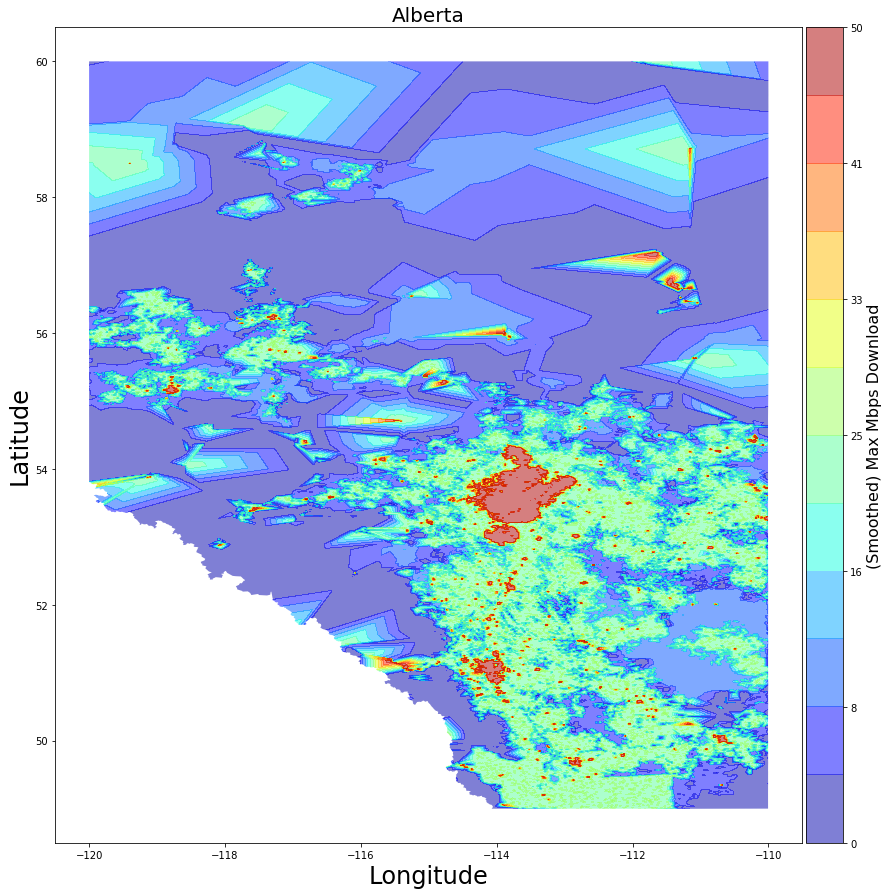

starting British Columbia


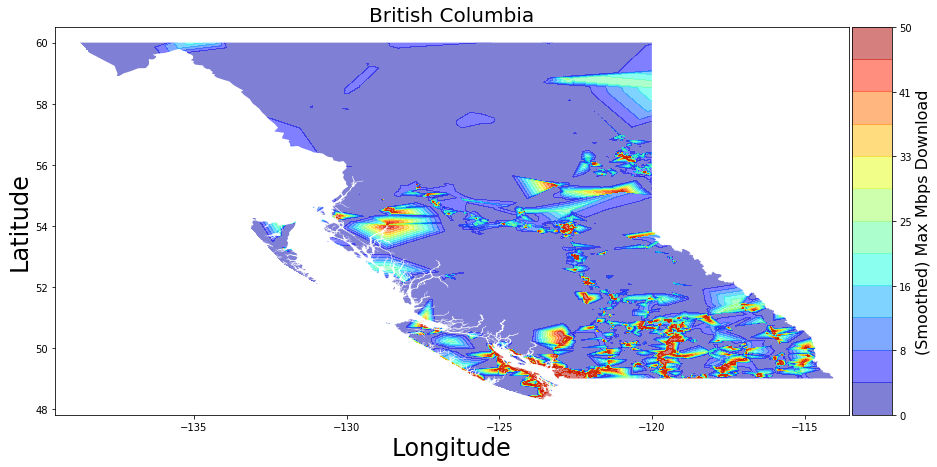

starting Yukon


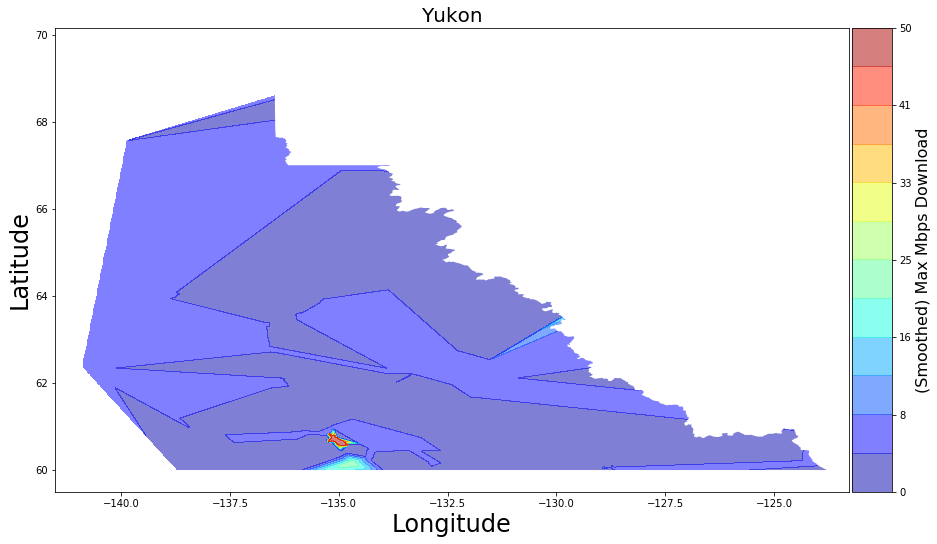

starting Northwest Territories


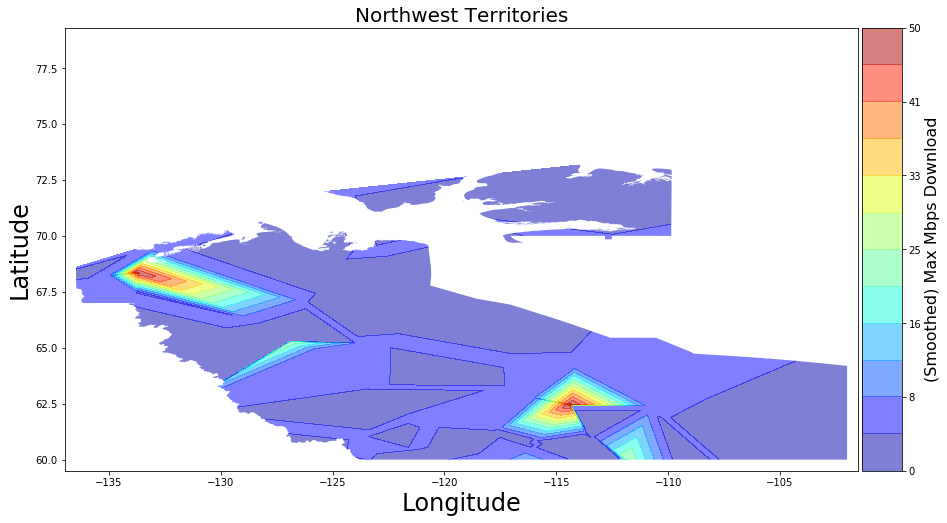

starting Nunavut


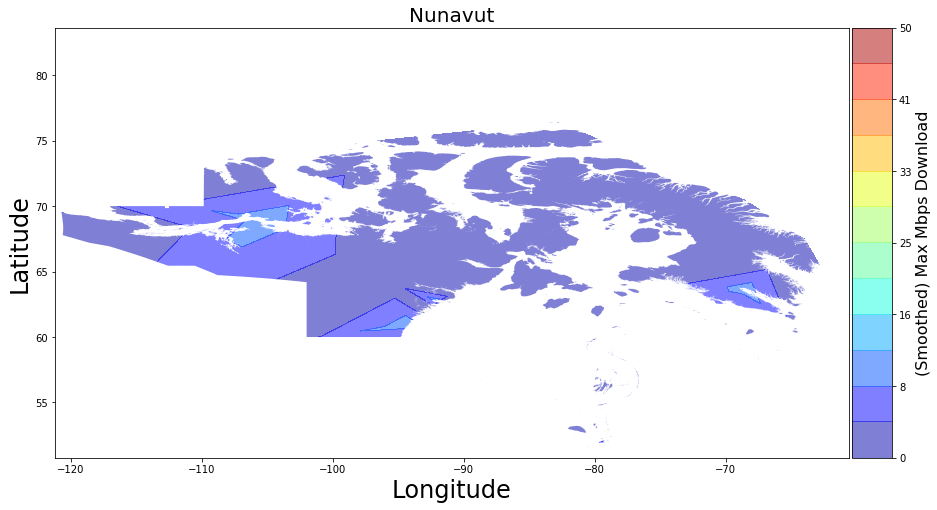

In [8]:
import matplotlib as mpl
from shapely.ops import cascaded_union
from shapely.geometry import Polygon, Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_patch(df):
    outer = Polygon(((-150, 35),(-150,100),(-50, 100),(-50,35)))
    df2 = gpd.GeoSeries(outer)
    df2 = gpd.GeoDataFrame(df2)
    df2.columns = ['geometry']
    res_difference = gpd.overlay(df2, df, how='difference')
    return res_difference

def make_interp(data, points, method):
    y = data['lat']
    x = data['long']
    z = data['speed']

    xi = np.linspace(x.min(), x.max(), points)
    yi = np.linspace(y.min(), y.max(), points)

    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method=method, rescale=True)
    zi[zi > 50 ] = 50
    
    return xi, yi, zi



def make_plot(data, patch, xi, yi, zi, box = None, title=None, interp='linear',
              plus = 0.5, point = None, save=False, file = 'test.png', 
              boundary=False):

    fig, ax = plt.subplots(figsize=(15,15))
    ax.axis('scaled')
    bound = np.linspace(0, 50, 13)
    CS = ax.contourf(xi,yi,zi,cmap=plt.cm.jet, vmin=0, vmax=50, alpha=.5, levels=bound)
    
    res_difference = make_patch(patch)
    res_difference.plot(ax=ax, color = 'white')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = fig.colorbar(CS, cax=cax)
    cbar.set_ticklabels([0, 8, 16, 25, 33, 41,50])
    
    cbar.set_label("(Smoothed) Max Mbps Download", size = 16)
    ax.set_xlabel("Longitude", size = 24)
    ax.set_ylabel("Latitude", size = 24)
    
    if box:
        ['minx', 'miny', 'maxx', 'maxy']
        ax.set_xlim([patch.bounds['minx'].values[0] -0.5, patch.bounds['maxx'].values[0] +0.5])
        ax.set_ylim([patch.bounds['miny'].values[0] -0.5, patch.bounds['maxy'].values[0] +0.5])
    if title:
        ax.set_title(title, size = 20)
        
    if save:
        plt.savefig(file, dpi=300)
    plt.show()
    
   
    
xi, yi, zi = make_interp(for_map, 5000, 'linear')
print('done interp')


for prov in dfcan['PRENAME'].unique():
    print("starting", prov)
    x =dfcan[dfcan['PRENAME'] == prov]
    make_plot(for_map, x, xi,yi,zi, plus = 0, save=False, 
            file = 'figures/' + str(prov) + '_heat.png', box = True, title =prov)
    
